# Learning-Based Frequency Transfer with PML

This notebook trains a neural network (SimpleFNO) to learn a *frequency transfer operator* for the 2D Helmholtz equation with Perfectly Matched Layers (PML).

Concretely, we want to approximate the mapping

$u_{\omega_\text{src}} \;\longmapsto\; u_{\omega_\text{tgt}}$

where \(u_{\omega}\) solves the PML-augmented Helmholtz problem on a fixed domain, for random point-source right-hand sides. The PDE solves themselves are handled in the `src/` package; this notebook focuses on:

1. setting up the numerical configuration (grid, PML, frequencies),
2. generating or loading a precomputed frequency-transfer dataset,
3. training a SimpleFNO model on this dataset,
4. evaluating its performance quantitatively and visually.


In [5]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt

# Find project root (dir containing src/)
here = Path().resolve()
PROJECT_ROOT = None
for parent in [here, *here.parents]:
    if (parent / "src" / "__init__.py").exists():
        PROJECT_ROOT = parent
        break

if PROJECT_ROOT is None:
    raise RuntimeError("Could not find project root with src/__init__.py")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)

from src.config import GridSpec, PMLConfig
from src.ml import SimpleFNO, train_model, eval_relative_metrics, get_freq_dataset


PROJECT_ROOT = C:\Users\31624\Documents\MIT\Programming\FreqTransfer


## 1. Numerical setup: grid, PML and frequencies

We first specify the numerical problem on which the learning task is based:

- a 2D Cartesian **grid** (`GridSpec`) describing the physical domain,
- a **PML configuration** (`PMLConfig`) that wraps the physical domain in an absorbing layer,
- a pair of **frequencies** $\omega_\text{src}$ and $\omega_\text{tgt}$,
- a mapping $\omega \mapsto k(\omega)$ from angular frequency to wavenumber.

These choices must be consistent with the PDE experiments in the rest of the project. The grid and PML completely determine the discrete Helmholtz operator that the solver in `src/` assembles.


In [6]:
# Grid configuration
grid = GridSpec(
    dims=2,
    shape=(48, 48),
    lengths=(1.0, 1.0),
)

# PML configuration (fixed "good" choice from your PML notebook)
pml_cfg = PMLConfig(
    thickness=16,
    m=2,
    sigma_max=10.0,
)

print("Grid:", grid)
print("PML:", pml_cfg)

# Frequency pair
omega_src = 20.0
omega_tgt = 40.0

def omega_to_k(omega: float) -> float:
    c = 1.0  # wave speed
    return float(omega / c)

print(f"omega_src = {omega_src}, omega_tgt = {omega_tgt}")
print(f"k_src = {omega_to_k(omega_src)}, k_tgt = {omega_to_k(omega_tgt)}")


Grid: GridSpec(dims=2, shape=(48, 48), lengths=(1.0, 1.0))
PML: PMLConfig(thickness=16, m=2, sigma_max=10.0)
omega_src = 20.0, omega_tgt = 40.0
k_src = 20.0, k_tgt = 40.0


## 2. Building (and caching) the frequency-transfer dataset

For each random point-source right-hand side, we solve the Helmholtz equation twice:

1. at $\omega_\text{src}$ → obtain $u_{\omega_\text{src}}$,
2. at $\omega_\text{tgt}$ → obtain $u_{\omega_\text{tgt}}$,

using the same grid and PML configuration. This gives one training pair $(u_\text{src}, u_\text{tgt})$.

The helper function `get_freq_dataset` wraps this process:

- On the **first call** for a given `(grid, PML config, ω_src, ω_tgt, N_samples)`:
  - it runs the PDE solver `N_samples` times,
  - stores all pairs $(u_\text{src}, u_\text{tgt})$ to `X.npy`, `Y.npy`,
  - writes metadata (frequencies, grid, PML, seeds) to `meta.json`,
  - and returns a `PrecomputedFreqDataset` that reads from disk.

- On **later calls** with the same parameters:
  - if the cache exists and is complete, it is loaded directly,
  - no PDE solves are performed.

In the cell below we request a dataset of `N_samples` frequency-transfer pairs and inspect the shape of a single sample.


In [7]:
N_samples = 200

dataset_raw = get_freq_dataset(
    grid=grid,
    pml=pml_cfg,
    omega_src=omega_src,
    omega_tgt=omega_tgt,
    N_samples=N_samples,
    omega_to_k=omega_to_k,
    overwrite=False,
)

print("Dataset length:", len(dataset))
u_src, u_tgt = dataset[0]
print("u_src shape:", u_src.shape, "u_tgt shape:", u_tgt.shape)


[get_freq_dataset] Loading cached dataset from: C:\Users\31624\Documents\MIT\Programming\FreqTransfer\data\freq_transfer_cached\wsrc20p000_wtgt40p000_N200_grid48x48_pmlT16_m2_sig10p00
  Loaded N=200 samples, ω_src=20.0, ω_tgt=40.0


NameError: name 'dataset' is not defined

## 3. Model: SimpleFNO and training procedure

We now define the learning model and training loop.

- The model is a **Simple Fourier Neural Operator (SimpleFNO)**:
  - input: a 2-channel field $u_\text{src}$ with `[Re, Im]` channels,
  - output: a 2-channel prediction for $u_\text{tgt}$,
  - architecture: several spectral convolution layers in Fourier space, plus local 1×1 convolutions.

- The training helper `train_model`:
  - splits the dataset into train/validation subsets,
  - uses an Adam optimiser with mean-squared error (MSE) loss,
  - reports train and validation loss per epoch,
  - runs on GPU if available, otherwise on CPU.

In the next cell we instantiate a SimpleFNO model with a chosen width, number of modes and layers, then train it for a fixed number of epochs.


In [ ]:
# Infer input channels from the *normalised* dataset
in_ch = dataset[0][0].shape[0]   # should still be 2 here
print("Input channels:", in_ch)

model = SimpleFNO(
    in_ch=in_ch,
    width=48,
    modes=(12, 12),
    layers=4,
)
print(model)

epochs = 50
batch_size = 16
lr = 1e-3

model, history = train_model(
    model=model,
    dataset=dataset,   # 👈 use the normalised dataset
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    val_split=0.2,
    device=None,
    verbose=True,
)


Input channels: 2
SimpleFNO(
  (proj_in): Conv2d(2, 48, kernel_size=(1, 1), stride=(1, 1))
  (spectral): ModuleList(
    (0-3): 4 x SpectralConv2d()
  )
  (w): ModuleList(
    (0-3): 4 x Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  )
  (act): GELU(approximate='none')
  (proj_out): Conv2d(48, 2, kernel_size=(1, 1), stride=(1, 1))
)
[001/50] train=2.5047e+01  val=7.8329e+00
[002/50] train=1.7317e+00  val=5.4850e-01
[003/50] train=1.6202e-01  val=4.5509e-02
[004/50] train=4.5566e-02  val=2.2256e-02
[005/50] train=1.2752e-02  val=9.5883e-03
[006/50] train=7.7700e-03  val=5.7463e-03
[007/50] train=4.6776e-03  val=3.7233e-03
[008/50] train=3.0647e-03  val=2.4598e-03
[009/50] train=2.2254e-03  val=1.9171e-03
[010/50] train=1.6885e-03  val=1.4503e-03
[011/50] train=1.3037e-03  val=1.1427e-03
[012/50] train=1.0328e-03  val=9.1015e-04
[013/50] train=8.2701e-04  val=7.3519e-04
[014/50] train=6.7250e-04  val=6.0199e-04
[015/50] train=5.5374e-04  val=4.9982e-04
[016/50] train=4.6280e-04  val

## 4. Training diagnostics and quantitative evaluation

After training, we want to understand:

1. **Optimisation behaviour**  
   We plot the training and validation MSE per epoch on a log scale.  
   This reveals whether the model:
   - converges smoothly,
   - overfits (train loss ↓, val loss ↑),
   - or underfits (both losses plateau at a high value).

2. **Overall prediction quality**  
   The function `eval_relative_metrics` evaluates the trained model on the full dataset and reports:
   - relative \(\ell_2\) errors,
   - magnitude-based errors,
   - phase-based errors.

Together, these provide a compact quantitative summary of how well the learned frequency-transfer operator approximates the true PDE mapping.


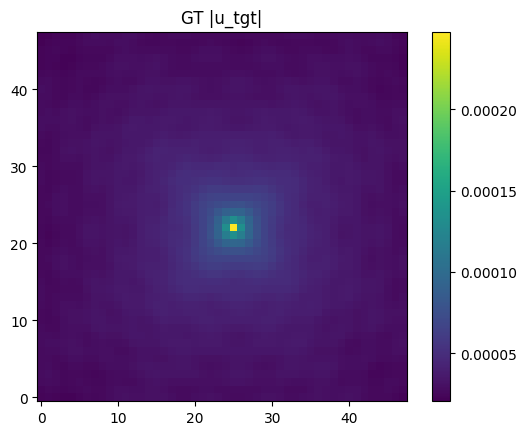

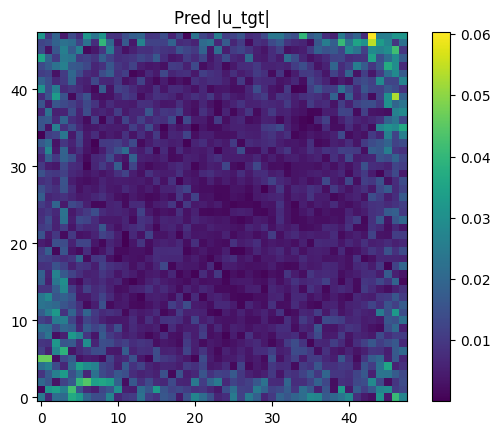

In [5]:
# Visual check for one sample
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

u_src, u_tgt = dataset[0]
with torch.no_grad():
    u_pred = model(u_src.unsqueeze(0).to(device)).cpu()[0]  # (2, H, W)

def plot_mag(u, title):
    u_np = u.numpy()
    u_c = u_np[0] + 1j * u_np[1]
    mag = abs(u_c)
    plt.figure()
    plt.imshow(mag, origin="lower")
    plt.colorbar()
    plt.title(title)
    plt.show()

plot_mag(u_tgt, "GT |u_tgt|")
plot_mag(u_pred, "Pred |u_tgt|")
